# Raw Data

Purpose of this notebook is to get the data to suitable
data structure for preprocessing.

The data were taken form antares server. Concretly,
from the `/data/ccd700` directory.

## FITS file format

https://fits.gsfc.nasa.gov/fits_primer.html

Flexible Image Transport System is data format used within
astronomy for transporting, analyzing, archiving scientific
data files. It is design to store data sets consisting of
multidimensiional arrays and two dimensional tables.

In [1]:
import os
import glob
import random
import fnmatch
import h5py
import astropy.io.fits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# find the normalized spectra in data_path directory
# normalized spectra filenames end with _norm.fit
# add all filenames to the list fits_paths
data_path = '/data/ccd700'
fits_paths = []
for root, dirname, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, '*_norm.fit'):
        fits_paths.append(root + '/' + filename)
len(fits_paths)

17056

In [3]:
# pick random fits
random_fits = random.choice(fits_paths)
random_fits

'/data/ccd700/rhoaur/6255-6767/kk160051_norm.fit'

### HDUs

A FITS file is comprised of segmets called Header/Data
Units (HDUs). The first HDU is called the 'Primary HDU'.
The primary data array can contain a 1-999 dimensional
array of numbers. A typical primary array could contain
a 1 dimensional **spectrum**, a 2 dimensional image,
a 3 dimensional data cube.

Any number of additional HDUs may follow the primary array.
These HDUs are referred as 'extensions'. There are three
types of standart extensions currently defined:

1. Image Extension (`XTENSION = 'IMAGE'`)
2. ASCII Table Extension (`XTENSION = 'TABLE'`)
3. Binary Table Extension (`XTENSION = 'BINTABLE'`)

In [4]:
# open file with astropy
hdulist = astropy.io.fits.open(random_fits)
# display info about the HDUs
hdulist.info()

Filename: /data/ccd700/rhoaur/6255-6767/kk160051_norm.fit
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     141   ()      
  1              BinTableHDU     19   1997R x 2C   [D, D]   


HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]


### Header Units

Every HDU consists of an ASCII formatted 'Header Unit' and
'Data Unit'.

Each header unit contains a sequence of fixed-length 80
character long keyword record which have form:

    KEYNAME = value / comment string

Non-printing ASCII character such as tabs,
carriage-returns, line-feeds are not allowed anywhere in
the header unit.

In [5]:
hdulist[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                    8 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
IRAF-TLM= '19:10:25 (06/11/2003)' / Time of last modification                   
OBJECT  = 'rho Aur '           / Title of observation                           
DATE    = '2003-11-06T18:10:25'/ Date FITS file was generated                   
SYSVER  = 'BIAS-headers'       / So lis  3 14:32:30 CET 2001                    
OBSERVAT= 'ONDREJOV'           / Name of observatory (IRAF style)               
LATITUDE=            49.910555 / Telescope latitude  (degrees), +49:54:38.0     
LONGITUD=            14.783611 / Telescope longitud  (degrees), +14:47:01.0     
HEIGHT  =                 05

In [6]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 1997 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'FLUX    '                                                            
TFORM2  = 'D       '        

### Data Units

Note that the data unit is not required. The image pixels
in primary array or an image extension may have one of
5 supported data types:

* 8-bit (unsigned) integer bytes
* 16-bit (signed) integer bytes
* 32-bit (signed) integer bytes
* 32-bit single precision floating point real numbers
* 64-bit double precision floating point real numbers

The othe 2 standard extensions, ASCII tables and binary
tables, contain tabular information organized into rows
and columns. Binary tables are more compact and are faster
to read and write then ASCII tables.

All the entries within a column of a tables have the same
datatype. The allowed data formats for an ASCII table
column are: integer, signe and double precision floating
point value, character string. Binary table also support
logical, bit and complex data formats.

In [7]:
data = hdulist[1].data
data

FITS_rec([( 6259.40874958,  0.9973034 ), ( 6259.66541957,  0.99816532),
       ( 6259.92208957,  0.99831462), ..., ( 6771.20872006,  0.99416363),
       ( 6771.46539005,  0.99015802), ( 6771.72206005,  0.98145552)], 
      dtype=(numpy.record, [('WAVE', '>f8'), ('FLUX', '>f8')]))

In [8]:
flux = data.field('FLUX')
wave = data.field('WAVE')
flux.shape, wave.shape

((1997,), (1997,))

The data can be ploted but it is missing correct
wavelength. To get wavelenght we use the `astropy.wcs`
module.

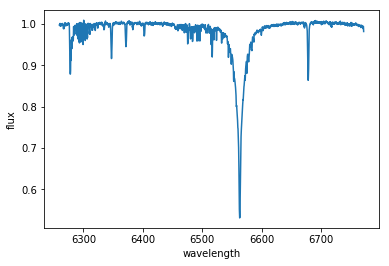

In [9]:
plt.plot(wave, flux)
plt.ylabel('flux')
plt.xlabel('wavelength')

In [10]:
def parse_fits_id(path):
    # path is /data/ccd700/fwcma/6260-6735/a201512070046_norm.fit
    # filename is a201512070046_norm.fit
    filename = os.path.split(path)[-1]
    # return values is a201512070046
    return filename.split('_')[0]

# http://astropy.readthedocs.io/en/latest/io/fits/appendix/faq.html#i-m-opening-many-fits-files-in-a-loop-and-getting-oserror-too-many-open-files
def parse_fits(filename):
    '''Parse normalized spectrum from fits file.
    Returns its id, wavelenght as np.array and
    flux as np.array. The data has to be in the
    second HDU an the flux and the wavelen need to
    be indexable be FLUX and WAVE keywords.'''
    try:
        with astropy.io.fits.open(filename, mmap=False) as hdulist:
            wave = hdulist[1].data['WAVE'].copy()
            flux = hdulist[1].data['FLUX'].copy()
    except IOError as e:
        print(e, filename)
        return None, None, None
    return parse_fits_id(filename), wave, flux

In [11]:
H_ALPHA = 6562.8

def in_range(start, stop, val=H_ALPHA):
    '''Check if val is in range [start, stop]'''
    return start <= val <= stop

def in_wavelen(wavelens, val=H_ALPHA):
    '''Check if val is somewhere in-between wavelens
    array start and end.'''
    return wavelens != None and in_range(wavelens[0], wavelens[-1], val)

In [12]:
# the data stucture is dict where a key is spectrum id
# and a value is dict of wavelen and flux
spectra = {
    fits_id: {'wave': wave, 'flux': flux}
    for fits_id, wave, flux in map(parse_fits, fits_paths)
    if in_wavelen(wave, H_ALPHA)
}
len(spectra)

/home/podondra/bt-text/notebooks/venv/lib/python3.4/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]


Empty or corrupt FITS file /data/ccd700/31peg/6255-6767/tg180041_norm.fit
Empty or corrupt FITS file /data/ccd700/31peg/8390-8900/tg180031_norm.fit
Empty or corrupt FITS file /data/ccd700/hd39478/6255-6767/tj300039_norm.fit


13345

## Save to HDF5

In [13]:
with h5py.File('data.hdf5', 'w') as f:
    for ident, data in spectra.items():
        for t in ['flux', 'wave']:
            group = 'spectra/' + ident + '/' + t
            dset = f.create_dataset(group, data[t].shape, dtype=data[t].dtype)
            dset[...] = data[t]